In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import tensorflow as tf
import numpy as np
import time
from resnet import generate_lenet_graph

In [2]:
# Read from the trained model
train_graph = tf.Graph()
with train_graph.as_default():
    with tf.Session() as session:
        saver = tf.train.import_meta_graph('/Users/taiyuanz/tensorflow/image_net/mnist_model/model.ckpt-19999.meta')
        saver.restore(session, '/Users/taiyuanz/tensorflow/image_net/mnist_model/model.ckpt-19999')
        graph = session.graph
        name_to_variables = dict([(v.name, session.run(v)) for v in graph.get_collection('variables')])
        
        print(name_to_variables["conv1/W:0"])

[[[[ 0.05113909  0.04381812  0.02659773 -0.01993001  0.04619731 -0.00452234
     0.03183864 -0.00510896  0.06517674 -0.03519627  0.11048368  0.02240274
     0.04311677  0.03847463  0.02527412  0.01453614  0.00101281  0.05337216
     0.03393031  0.06977642  0.02160246 -0.1578251  -0.08632866  0.09886949
     0.08256903  0.08528065  0.00029364 -0.00527354  0.0232158   0.10365336
     0.01000161  0.09755064]]

  [[ 0.00959306  0.10670724  0.03894611  0.01175356  0.11329081  0.02166279
     0.06193409  0.02069947  0.11469997 -0.06113772  0.10202844  0.04823137
     0.07901468  0.04659472  0.08734411  0.06789946  0.04330951  0.01960913
     0.00328808  0.07450893  0.10065265 -0.21477632 -0.08345801  0.06573732
     0.08823162  0.09863298 -0.07746028  0.02518265  0.06701902  0.13868143
     0.009212    0.09760997]]

  [[-0.09993755  0.09136302  0.05836122  0.01631213  0.13324833  0.04169635
     0.07370796  0.03865109  0.11506147 -0.10936466  0.02597795  0.08114966
     0.04497865  0.0479743

In [7]:
labels = range(10)
num_samples = 20
num_train_iter = 1000
label_to_samples = {}
alpha = 1e-4

test_graph = tf.Graph()
with test_graph.as_default():
    with tf.Session() as session:
        test_session = session
        X = tf.Variable(tf.truncated_normal([num_samples, 28, 28, 1], stddev=0.01), name='X')
        Y_pred_activation = generate_lenet_graph(X)
        Xsquare = tf.square(X)
        penalty = tf.reduce_sum(tf.sqrt(tf.reduce_sum(Xsquare, (1,2))), 0)
        Y_placeholder = tf.placeholder(tf.int32, shape=[None, 10], name='Y')
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y_pred_activation, Y_placeholder))
        # + alpha * penalty
        grad_op = tf.train.AdamOptimizer(1e-3).minimize(loss, var_list=[X])
        session.run(tf.global_variables_initializer())
        
        for v in test_graph.get_collection('variables'):
            if v.name not in name_to_variables:
                print('Variable not found %s' % v.name)
                continue

            value = name_to_variables[v.name]
            print(v.name, v)
            session.run(v.assign(value))
        
        train_op = test_graph.get_operation_by_name('Adam')
        # X = test_graph.get_tensor_by_name('X:0')
        Y_pred_activation = test_graph.get_tensor_by_name('pred/add:0')
        W = test_graph.get_tensor_by_name('conv1/W:0')
        # print(session.run(W))

        for label in labels:
            print ("Running label %d" % label)
            label_to_samples[label] = []
            
            Y_target = np.zeros((num_samples, 10), dtype=int)
            Y_target[:, label] = 1

            # Initialize X to a random number
            session.run(X.assign(np.asarray(np.random.randn(num_samples, 28 * 28)).reshape((num_samples, 28, 28, 1))))
            for i in range(num_train_iter):
                session.run(train_op, feed_dict={Y_placeholder: Y_target})

                if i % 200 == 0:
                    y = session.run(Y_pred_activation)
                    print("Index: ", i, y.argmax(axis=1), y[:, label])

            label_to_samples[label].append(session.run(X))

        

Variable not found X:0
conv1/W:0 Tensor("conv1/W/read:0", shape=(5, 5, 1, 32), dtype=float32, device=/device:CPU:0)
conv1/b:0 Tensor("conv1/b/read:0", shape=(32,), dtype=float32, device=/device:CPU:0)
Variable not found conv2/W:0
Variable not found conv2/b:0
fc/W:0 Tensor("fc/W/read:0", shape=(3136, 1024), dtype=float32, device=/device:CPU:0)
fc/W_1:0 Tensor("fc/W_1/read:0", shape=(1024,), dtype=float32, device=/device:CPU:0)
pred/W:0 Tensor("pred/W/read:0", shape=(1024, 10), dtype=float32, device=/device:CPU:0)
pred/b:0 Tensor("pred/b/read:0", shape=(10,), dtype=float32, device=/device:CPU:0)
beta1_power:0 Tensor("beta1_power/read:0", shape=(), dtype=float32)
beta2_power:0 Tensor("beta2_power/read:0", shape=(), dtype=float32)
Variable not found X/Adam:0
Variable not found X/Adam_1:0
Running label 0
Index:  0 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5] [-2.61008048 -2.81456423 -2.67557311 -2.45765305 -2.61726284 -2.77917504
 -2.50981808 -2.54539847 -2.34550285 -2.47132254 -2.220505   -2.

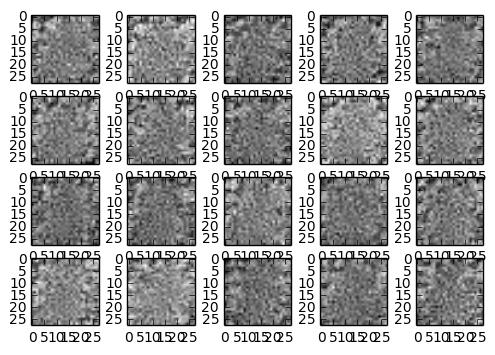

In [68]:
from matplotlib import pyplot as plt

row = 4
col = 5
fig, axarr = plt.subplots(row, col)

imgs = np.asarray(label_to_samples[8]).squeeze()
for r in range(row):
    for c in range(col):
        img = imgs[r * col + c, :, :].squeeze()
        img = img - img.min(axis=(0, 1))
        # print(img)
        img = img / img.max(axis=(0, 1)) * 255.0
        # print(img)
        axarr[r, c].imshow(img, cmap='gray')
        # break


In [32]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('/Users/taiyuanz/tensorflow/image_net/mnist_data')

Extracting /Users/taiyuanz/tensorflow/image_net/mnist_data/train-images-idx3-ubyte.gz
Extracting /Users/taiyuanz/tensorflow/image_net/mnist_data/train-labels-idx1-ubyte.gz
Extracting /Users/taiyuanz/tensorflow/image_net/mnist_data/t10k-images-idx3-ubyte.gz
Extracting /Users/taiyuanz/tensorflow/image_net/mnist_data/t10k-labels-idx1-ubyte.gz


In [47]:
x, y = mnist_data.train.next_batch(32)

y

array([6, 6, 9, 7, 3, 8, 9, 9, 3, 0, 8, 1, 3, 2, 0, 3, 2, 4, 9, 5, 9, 6, 4,
       7, 3, 8, 4, 9, 3, 6, 5, 2], dtype=uint8)

In [48]:
np.where(y == 6)

(array([ 0,  1, 21, 29]),)

In [49]:
x.shape

(32, 784)

In [51]:
np.random.standard_normal(100)

array([ 0.26806472,  0.06319465,  0.52474696, -1.18638785,  0.59912884,
        0.69227536, -2.08798792, -0.58684299, -0.48418262, -1.07233145,
        0.71177585,  1.18479432,  0.1048661 ,  0.00417651, -1.05382187,
       -0.73798049, -1.45192626,  0.85490937,  0.66364953,  0.35091625,
       -0.24137106, -0.75876971, -1.09456811,  0.67705033, -0.47050818,
       -1.30629606, -0.9547    , -0.33354506,  1.88022896, -2.01822284,
       -0.06525345,  0.33300746,  0.52666417, -0.90607095,  0.07840228,
        0.13005563, -0.12848024, -0.54616441,  0.0826097 ,  2.87294491,
       -2.38378805, -1.27004767,  1.69055107,  0.11561125, -0.47186767,
       -0.99939038, -0.35382354, -0.16070221,  0.74281377,  0.25086723,
        1.7264666 ,  0.94420263,  0.19889193,  0.14154871, -0.65716142,
        0.28055233, -0.37547012,  0.59067526,  0.33665478,  0.42077829,
       -0.41913629, -0.4249573 , -0.20397895,  1.42890227, -1.52487517,
       -0.20301808,  0.90406554, -0.03323424, -0.31390094, -1.06

In [72]:
arr = np.asarray([[[1,2],[3,4]], [[11,12],[13,14]], [[21,22],[23,24]]])
print(arr.shape)
arr.reshape((3,4)).reshape((3, 2, 2))

(3, 2, 2)


array([[[ 1,  2],
        [ 3,  4]],

       [[11, 12],
        [13, 14]],

       [[21, 22],
        [23, 24]]])